In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from math import pi

In [31]:
data = pd.read_csv("p2-arbres-fr.csv", sep=";")
data.head()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


In [32]:
print(data.shape)
print(data.dtypes)
data.isna().mean()

(200137, 18)
id                       int64
type_emplacement        object
domanialite             object
arrondissement          object
complement_addresse     object
numero                 float64
lieu                    object
id_emplacement          object
libelle_francais        object
genre                   object
espece                  object
variete                 object
circonference_cm         int64
hauteur_m                int64
stade_developpement     object
remarquable            float64
geo_point_2d_a         float64
geo_point_2d_b         float64
dtype: object


id                     0.000000
type_emplacement       0.000000
domanialite            0.000005
arrondissement         0.000000
complement_addresse    0.845596
numero                 1.000000
lieu                   0.000000
id_emplacement         0.000000
libelle_francais       0.007480
genre                  0.000080
espece                 0.008754
variete                0.816241
circonference_cm       0.000000
hauteur_m              0.000000
stade_developpement    0.335795
remarquable            0.315274
geo_point_2d_a         0.000000
geo_point_2d_b         0.000000
dtype: float64

En inspectant les données, on se rend compte que le complément d'adresse, le numéro et la variété sont trop vides pour être utilisés. Les variables remarquables et stade de développement pourraient être exploité, mais en regardant les données, on se rend compte qu'elle ne sont pas très intéressante. Nous pouvons donc nous débarrasser de toutes ces variables.

In [33]:
data.drop(["complement_addresse", "numero", "variete", "remarquable", "stade_developpement"], axis="columns", inplace=True)

En regardant la variable "type emplacement", on a l'impression qu'elle ne comporte que la valeur "arbre" ce qui la rendrait inutile. Nous allons vérifier, et si c'est bien le cas, nous pourrons la supprimer.

In [34]:
data["type_emplacement"].unique()

array(['Arbre'], dtype=object)

In [35]:
data.drop("type_emplacement", axis="columns", inplace=True)
data.head()

,id,domanialite,arrondissement,lieu,id_emplacement,libelle_francais,genre,espece,circonference_cm,hauteur_m,geo_point_2d_a,geo_point_2d_b
0,99874,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,20,5,48.857620,2.320962
1,99875,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,65,8,48.857656,2.321031
2,99876,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,90,10,48.857705,2.321061
3,99877,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,60,8,48.857722,2.321006
4,99878,Jardin,PARIS 17E ARRDT,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,38,0,48.890435,2.315289


Nous allons aussi vérifier qu'il n'y a pas de duplicata.

In [36]:
data["id"].duplicated().sum()

np.int64(0)

Nous allons regarder de plus près les variables quantitatives pour détecter de potentiels outliers.

In [37]:
data.describe()

,id,circonference_cm,hauteur_m,geo_point_2d_a,geo_point_2d_b
count,2.001370e+05,200137.000000,200137.000000,200137.000000,200137.000000
mean,3.872027e+05,83.380479,13.110509,48.854491,2.348208
std,5.456032e+05,673.190213,1971.217387,0.030234,0.051220
min,9.987400e+04,0.000000,0.000000,48.742290,2.210241
25%,1.559270e+05,30.000000,5.000000,48.835021,2.307530
50%,2.210780e+05,70.000000,8.000000,48.854162,2.351095
75%,2.741020e+05,115.000000,12.000000,48.876447,2.386838
max,2.024745e+06,250255.000000,881818.000000,48.911485,2.469759


Effectivement, les variables de circonférence et de hauteur ont des variables beaucoup trop hautes. Nous allons donc les supprimer. Profitons en pour en savoir un peu plus concernant ces dernières.

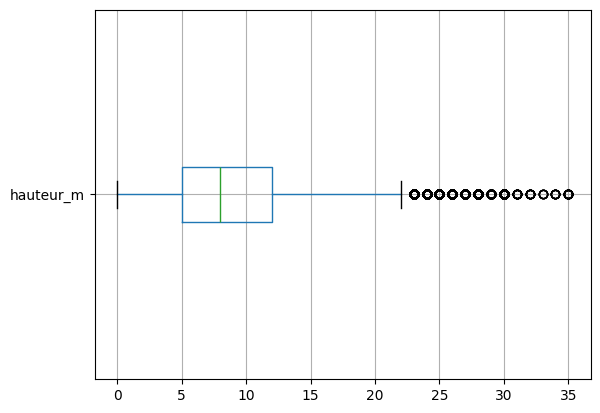

La hauteur moyenne d'un arbre est de 8.32m


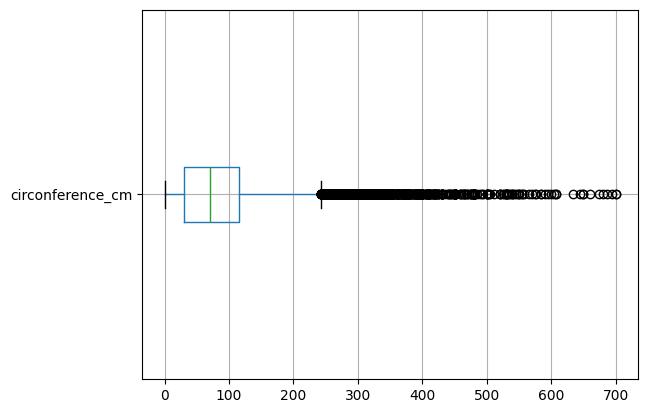

La circonference moyenne d'un arbre est de 79.62cm


In [38]:
data.loc[data["hauteur_m"] > 35, "hauteur_m"] = np.nan
data.loc[data["circonference_cm"] > 700, "circonference_cm"] = np.nan
data.boxplot(column="hauteur_m", vert=False)
plt.show()
print("La hauteur moyenne d'un arbre est de {}m".format(data["hauteur_m"].mean().round(2)))
data.boxplot(column="circonference_cm", vert=False)
plt.show()
print("La circonference moyenne d'un arbre est de {}cm".format(data["circonference_cm"].mean().round(2)))

Pour y voir plus clair aux données géographiques, nous allons utiliser folium, une librairie nous permettant de créer une carte interactive sur laquelle nous pourrons placer nos arbres.

In [39]:
tree_location_by_district = data.groupby("arrondissement")[["geo_point_2d_a", "geo_point_2d_b"]].mean()
tree_number_by_district = data.groupby("arrondissement").size()
tree_location_by_zone_list = tree_location_by_district.values.tolist()
tree_map = folium.Map((data["geo_point_2d_a"].mean(), data["geo_point_2d_b"].mean()), zoom_start=12)
for zone in range(0, len(tree_location_by_zone_list)):
    district = tree_number_by_district.keys()[zone].capitalize().replace("arrdt", "arrondissement")
    html = """{}<br>
    <center>{} Arbres</center>""".format(district, tree_number_by_district[zone])
    folium.Marker(tree_location_by_zone_list[zone], popup=folium.Popup(html, max_width=200), icon=folium.Icon(color="green", icon_color="white", icon="tree", prefix='fa')).add_to(tree_map)
tree_map

C:\Users\barth\AppData\Local\Temp\ipykernel_18388\3221245201.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  <center>{} Arbres</center>""".format(district, tree_number_by_district[zone])


In [40]:
tree_number_by_district.sort_values(ascending=False)

arrondissement
PARIS 15E ARRDT      17151
PARIS 13E ARRDT      16712
PARIS 16E ARRDT      16403
PARIS 20E ARRDT      15340
PARIS 19E ARRDT      13709
PARIS 12E ARRDT      12600
SEINE-SAINT-DENIS    11570
BOIS DE VINCENNES    11510
PARIS 14E ARRDT      11399
PARIS 17E ARRDT      10762
PARIS 18E ARRDT      10011
PARIS 7E ARRDT        8617
VAL-DE-MARNE          7580
PARIS 8E ARRDT        7245
PARIS 11E ARRDT       5658
HAUTS-DE-SEINE        5298
BOIS DE BOULOGNE      3978
PARIS 10E ARRDT       3385
PARIS 4E ARRDT        2740
PARIS 5E ARRDT        2368
PARIS 6E ARRDT        1764
PARIS 1ER ARRDT       1413
PARIS 3E ARRDT        1209
PARIS 9E ARRDT        1167
PARIS 2E ARRDT         548
dtype: int64

Nous avons affiché sur la carte les arbres et nous avons créé une liste rangeant les arrondissements par le nombre d'arbres qu'ils contiennent. Cela devrait nous donner une idée des arrondissements à privilégier mais nous pouvons aller plus loin. En supposant que plus un arbre est volumineux, plus il prend du temps à entretenir, on pourrait supposé qu'une grosse partie des arbres dans certains arrondissements sont des arbrisseaux, et donc qu'ils prendraient peu de temps à entretenir. Pour illustré ça, nous allons calculer le volume de chaque arbre, puis additionnés le volume de tous les arbres par arrondissement, et enfin, pour y voir plus clair, nous allons en faire un score.

In [41]:
data["volume"] = (data["circonference_cm"] / (2 * pi))**2 * pi * data["hauteur_m"]
data["volume"]
total_volume_by_district = pd.DataFrame(data.groupby("arrondissement")["volume"].sum())
total_volume_by_district["score"] = total_volume_by_district.values / total_volume_by_district.values.max()
total_volume_by_district["score"].sort_values(ascending=False)

arrondissement
PARIS 16E ARRDT      1.000000
PARIS 20E ARRDT      0.753253
PARIS 19E ARRDT      0.749355
PARIS 14E ARRDT      0.640358
VAL-DE-MARNE         0.629797
BOIS DE VINCENNES    0.605868
PARIS 12E ARRDT      0.578391
PARIS 8E ARRDT       0.537937
PARIS 13E ARRDT      0.530786
PARIS 7E ARRDT       0.519374
PARIS 17E ARRDT      0.444068
PARIS 15E ARRDT      0.420406
PARIS 18E ARRDT      0.406966
SEINE-SAINT-DENIS    0.383540
PARIS 11E ARRDT      0.240612
PARIS 10E ARRDT      0.196755
PARIS 4E ARRDT       0.169205
PARIS 5E ARRDT       0.150203
BOIS DE BOULOGNE     0.141664
PARIS 6E ARRDT       0.102913
PARIS 1ER ARRDT      0.061784
PARIS 3E ARRDT       0.053741
PARIS 9E ARRDT       0.052133
HAUTS-DE-SEINE       0.031339
PARIS 2E ARRDT       0.020924
Name: score, dtype: float64

Grâce à cette dernière analyse, nous nous rendons compte que certains arrondissements ont des arbres en moyenne beaucoup moins volumineux que d'autres. L'exemple le plus flagrant est le 15e arrondissement qui est premier dans la liste du nombre d'arbres alors qu'il est douzième dans la liste des volumes.